In [16]:
# 📦 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

# Optional: Association rules if needed
# from mlxtend.frequent_patterns import apriori, association_rules

In [17]:
# 📥 Load Dataset
df = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
# 📊 Initial Exploration
print("Dataset shape:", df.shape)
print(df.head())
print(df.info())
print(df.describe())


Dataset shape: (541909, 8)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       -------------- 

In [18]:
# ✅ Data Cleaning
df = df.dropna(subset=['CustomerID'])  # Drop rows without customer ID
df = df[df['Quantity'] > 0]            # Keep only positive quantity orders
df = df[df['UnitPrice'] > 0]           # Remove invalid prices

# Create TotalPrice
df['TotalPrice'] = df['UnitPrice'] * df['Quantity']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [19]:
# 📦 Aggregate Customer-Level Data
customer_df = df.groupby('CustomerID').agg({
    'TotalPrice': 'sum',
    'InvoiceNo': pd.Series.nunique,
    'InvoiceDate': ['min', 'max'],
    'Quantity': 'sum'
})

# Flatten MultiIndex columns
customer_df.columns = ['TotalSpend', 'InvoiceCount', 'FirstPurchase', 'LastPurchase', 'TotalQuantity']
customer_df = customer_df.reset_index()


In [20]:
# ✅ Calculate Metrics
today = pd.Timestamp('2025-09-10')
customer_df['Recency'] = (today - customer_df['LastPurchase']).dt.days
customer_df['Frequency'] = customer_df['InvoiceCount']
customer_df['AvgOrderValue'] = customer_df['TotalSpend'] / customer_df['InvoiceCount']

In [21]:
# 📊 RFM Normalization
scaler = MinMaxScaler()
customer_df[['Recency_norm', 'Frequency_norm', 'TotalSpend_norm']] = scaler.fit_transform(
    customer_df[['Recency', 'Frequency', 'TotalSpend']]
)

# Weighted RFM Score
customer_df['RFM_Score'] = (0.4 * (1 - customer_df['Recency_norm']) +
                            0.3 * customer_df['Frequency_norm'] +
                            0.3 * customer_df['TotalSpend_norm'])

In [22]:
# ✅ Customer Lifetime Value (CLV)
margin_rate = 0.3
customer_df['CLV'] = customer_df['TotalSpend'] * margin_rate * customer_df['Frequency'] / customer_df['InvoiceCount']

In [23]:
# 📊 Anomaly Detection using Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
customer_df['Anomaly'] = iso_forest.fit_predict(customer_df[['TotalSpend', 'Frequency']])
customer_df['Anomaly'] = customer_df['Anomaly'].map({1: 'Normal', -1: 'Anomaly'})

In [24]:
# 📊 Clustering using K-Means
features = customer_df[['Recency_norm', 'Frequency_norm', 'TotalSpend_norm']]
kmeans = KMeans(n_clusters=4, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(features)

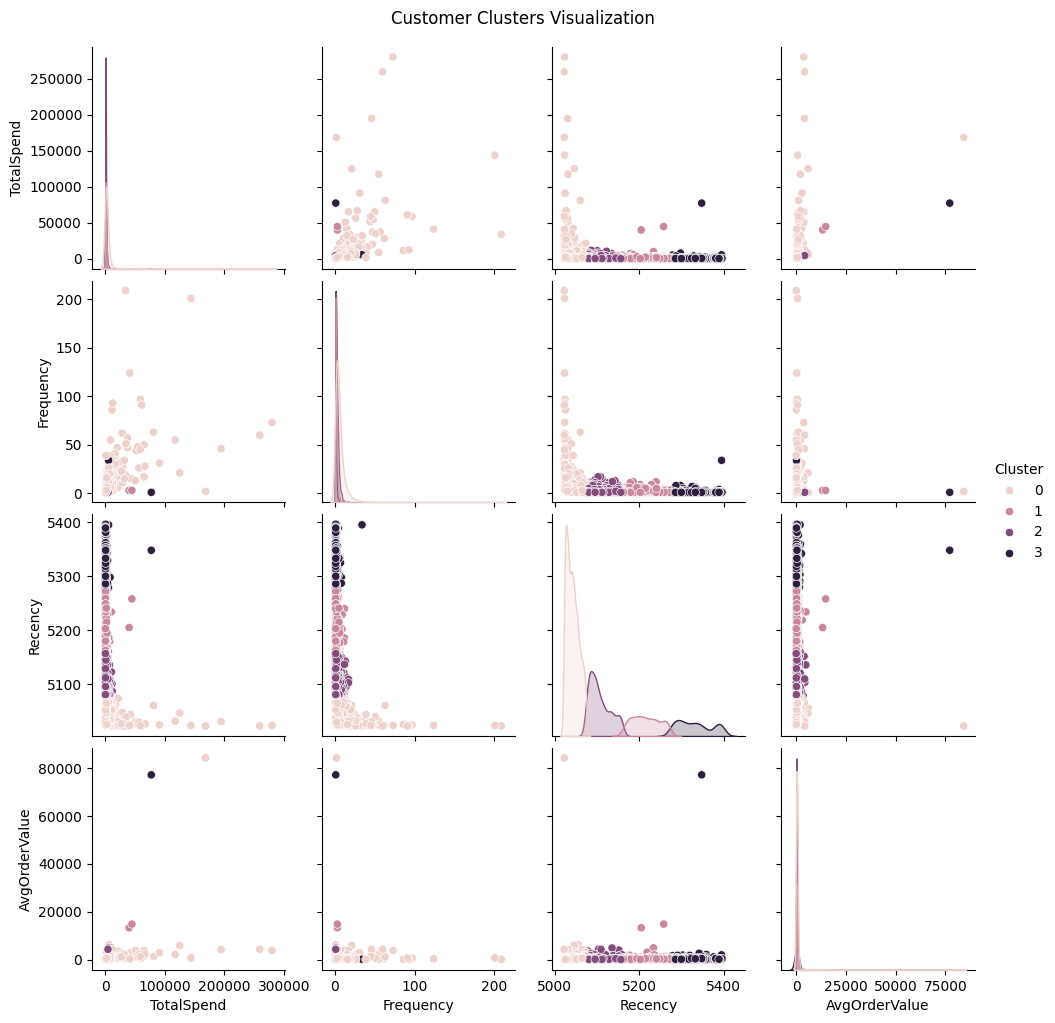

In [25]:
# 📈 Visualizing Clusters
sns.pairplot(customer_df, hue='Cluster', vars=['TotalSpend', 'Frequency', 'Recency', 'AvgOrderValue'])
plt.suptitle("Customer Clusters Visualization", y=1.02)
plt.show()

In [26]:
# ✅ Cluster Summary
cluster_summary = customer_df.groupby('Cluster').agg({
    'TotalSpend': ['mean', 'sum'],
    'Frequency': ['mean', 'sum'],
    'Recency': 'mean',
    'AvgOrderValue': 'mean',
    'CLV': ['mean', 'sum'],
    'CustomerID': 'count'
}).reset_index()
cluster_summary.columns = ['Cluster', 'AvgTotalSpend', 'SumTotalSpend', 'AvgFrequency', 'SumFrequency',
                           'AvgRecency', 'AvgOrderValue', 'AvgCLV', 'SumCLV', 'CustomerCount']
print(cluster_summary)

   Cluster  AvgTotalSpend  SumTotalSpend  AvgFrequency  SumFrequency  \
0        0    3238.658814    7150958.661      6.356431         14035   
1        1     721.201958     431278.771      1.864548          1115   
2        2    1012.092214    1047515.442      2.619324          2711   
3        3     566.710322     281655.030      1.350101           671   

    AvgRecency  AvgOrderValue      AvgCLV        SumCLV  CustomerCount  
0  5042.832428     428.550649  971.597644  2.145288e+06           2208  
1  5216.018395     364.702093  216.360587  1.293836e+05            598  
2  5106.885024     409.060600  303.627664  3.142546e+05           1035  
3  5331.486922     464.052230  170.013097  8.449651e+04            497  


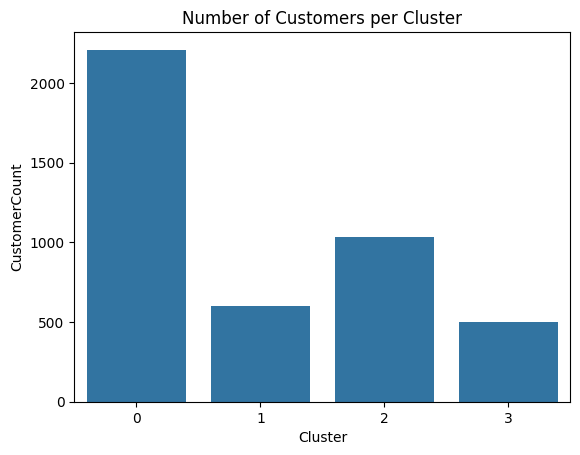

In [27]:
# 📊 Plotting Cluster Sizes
sns.barplot(data=cluster_summary, x='Cluster', y='CustomerCount')
plt.title('Number of Customers per Cluster')
plt.show()

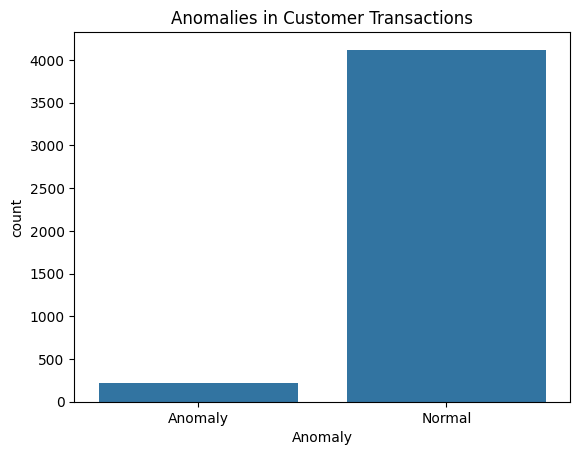

In [28]:
# ✅ Anomaly Distribution
sns.countplot(data=customer_df, x='Anomaly')
plt.title('Anomalies in Customer Transactions')
plt.show()


In [29]:
# ✅ Insights by Cluster
for cluster in sorted(customer_df['Cluster'].unique()):
    group = customer_df[customer_df['Cluster'] == cluster]
    print(f"\nCluster {cluster} Summary:")
    print(f" - Number of Customers: {group.shape[0]}")
    print(f" - Average Spend: ${group['TotalSpend'].mean():.2f}")
    print(f" - Average Recency: {group['Recency'].mean():.2f} days")
    print(f" - Average Frequency: {group['Frequency'].mean():.2f}")
    print(f" - Average CLV: ${group['CLV'].mean():.2f}")



Cluster 0 Summary:
 - Number of Customers: 2208
 - Average Spend: $3238.66
 - Average Recency: 5042.83 days
 - Average Frequency: 6.36
 - Average CLV: $971.60

Cluster 1 Summary:
 - Number of Customers: 598
 - Average Spend: $721.20
 - Average Recency: 5216.02 days
 - Average Frequency: 1.86
 - Average CLV: $216.36

Cluster 2 Summary:
 - Number of Customers: 1035
 - Average Spend: $1012.09
 - Average Recency: 5106.89 days
 - Average Frequency: 2.62
 - Average CLV: $303.63

Cluster 3 Summary:
 - Number of Customers: 497
 - Average Spend: $566.71
 - Average Recency: 5331.49 days
 - Average Frequency: 1.35
 - Average CLV: $170.01


In [30]:
# ✅ Save Results (Optional)
customer_df.to_csv('customer_segmentation_results.csv', index=False)
cluster_summary.to_csv('cluster_summary.csv', index=False)